In [2]:
# 1. Načítanie knižníc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2. Načítanie oboch CSV
df1 = pd.read_csv("../.scratch/final_onlyai_4.csv")
df2 = pd.read_csv("../.scratch/all_predictions_fs2_lr_gamma_up2.csv")  # druhé CSV

# Spraviť predspracovanie pre obidve
for df in [df1, df2]:
    df["base_filename"] = df["filename"].str.extract(r"(instance_\d+)_")
    df["chance_id"] = df['chance'].astype(str) + '_' + df["base_filename"] + "_" + df["bool"].astype(str) + "_" + df["side"]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Funkcia na výpočet derivácie cez klzavé okno
def moving_average_derivative(values, window_size=5):
    return np.diff(np.convolve(values, np.ones(window_size)/window_size, mode='valid'))

# Funkcia na výpočet druhej derivácie
def second_derivative(values):
    first_derivative = np.diff(values)
    return np.diff(first_derivative)

# Funkcia na výpočet druhej derivácie pohyblivého priemeru
def second_moving_average_derivative(values, window_size=5):
    moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return second_derivative(moving_avg)

# Funkcia na výpočet max hodnoty pohyblivého priemeru
def max_moving_average(values, window_size=5):
    moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return np.max(np.abs(moving_avg))

# Funkcia na výpočet metriky pre každú šancu
def compute_metrics(df):
    metrics = []
    
    for chance_id, group in df.groupby("chance_id"):
        values = group["value"].values

        # Max abs value
        max_abs_value = np.max(np.abs(values))

        # min max diff
        min_max_diff = np.abs(np.max(values) - np.min(values))
        
        # Priemer najväčších 10 hodnôt
        top_10_avg = np.mean(np.sort(np.abs(values))[-10:])
        
        # Max derivácia
        first_derivative = np.abs(np.diff(values))
        max_derivative = np.max(first_derivative)
        
        # Max druhá derivácia
        second_derivative_vals = np.abs(second_derivative(values))
        max_second_derivative = np.max(second_derivative_vals)
        
        # Derivácia priemeru klzavého okna
        moving_avg_derivative = np.abs(moving_average_derivative(values))
        max_moving_avg_derivative = np.max(moving_avg_derivative)
        
        # Druhá derivácia pohyblivého priemeru
        second_moving_avg_derivative_vals = np.abs(second_moving_average_derivative(values))
        max_second_moving_avg_derivative = np.max(second_moving_avg_derivative_vals)
        
        # Max hodnoty pohyblivého priemeru
        max_moving_value = np.abs(max_moving_average(values))
        
        metrics.append({
            "chance_id": chance_id,
            "max_abs_value": max_abs_value,
            "top_10_avg": top_10_avg,
            "min_max_diff": min_max_diff,
            "max_derivative": max_derivative,
            "max_second_derivative": max_second_derivative,
            "max_moving_derivative": max_moving_avg_derivative,
            "max_second_moving_derivative": max_second_moving_avg_derivative,
            "max_moving_value": max_moving_value,
            "true_label": group["chance"].iloc[0]  # Predpokladáme, že všetky hodnoty v skupine sú rovnaké
        })
    
    return pd.DataFrame(metrics)


def find_precision_recall_intersection(thresholds, precision, recall):
    for i in range(len(thresholds) - 1):
        p1, p2 = precision[i], precision[i + 1]
        r1, r2 = recall[i], recall[i + 1]

        # Skontroluj, či sa krivky pretínajú medzi i a i+1
        if (p1 - r1) * (p2 - r2) < 0:
            # Lineárna interpolácia pre threshold, kde sa pretínajú
            t1, t2 = thresholds[i], thresholds[i + 1]

            # Rozdiely
            dp = p2 - p1
            dr = r2 - r1
            dt = t2 - t1

            # Riešime rovnicu p(t) = r(t)
            alpha = (r1 - p1) / ((dp - dr) + 1e-8)
            t_cross = t1 + alpha * dt

            # Interpoluj aj hodnotu precision = recall
            precision_interp = p1 + alpha * dp
            return t_cross, precision_interp

    # Ak sa nikdy nepretli, vráť najbližší bod
    i = np.argmin(np.abs(np.array(precision) - np.array(recall)))
    return thresholds[i], (precision[i] + recall[i]) / 2


def evaluate_thresholds_compare(df_metrics1, df_metrics2, column, thresholds=np.linspace(-1, 1, 1000)):
    precision1, recall1 = [], []
    precision2, recall2 = [], []

    for t in thresholds:
        preds1 = df_metrics1[column] > t
        tp1 = ((preds1 == True) & (df_metrics1["true_label"] == True)).sum()
        fp1 = ((preds1 == True) & (df_metrics1["true_label"] == False)).sum()
        fn1 = ((preds1 == False) & (df_metrics1["true_label"] == True)).sum()

        prec1 = tp1 / (tp1 + fp1 + 1e-8)
        rec1 = tp1 / (tp1 + fn1 + 1e-8)
        
        preds2 = df_metrics2[column] > t
        tp2 = ((preds2 == True) & (df_metrics2["true_label"] == True)).sum()
        fp2 = ((preds2 == True) & (df_metrics2["true_label"] == False)).sum()
        fn2 = ((preds2 == False) & (df_metrics2["true_label"] == True)).sum()

        prec2 = tp2 / (tp2 + fp2 + 1e-8)
        rec2 = tp2 / (tp2 + fn2 + 1e-8)

        precision1.append(prec1)
        recall1.append(rec1)
        precision2.append(prec2)
        recall2.append(rec2)

    t1, score1 = find_precision_recall_intersection(thresholds, precision1, recall1)
    t2, score2 = find_precision_recall_intersection(thresholds, precision2, recall2)

    print(f"Dataset1 - {column}:")
    print(f"  Precision ≈ Recall ≈ {score1:.3f} at threshold ≈ {t1:.3f}")

    print(f"Dataset2 - {column}:")
    print(f"  Precision ≈ Recall ≈ {score2:.3f} at threshold ≈ {t2:.3f}")

    # Vybereme 2 farby pre precision a recall
    color_precision = "#1f77b4"  # modrá
    color_recall = "#ff7f0e"     # oranžová

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision1, label=f"Dataset1 - {column} - Precision", linestyle='-', color=color_precision)
    plt.plot(thresholds, recall1, label=f"Dataset1 - {column} - Recall", linestyle='-', color=color_recall)

    plt.plot(thresholds, precision2, label=f"Dataset2 - {column} - Precision", linestyle='--', color=color_precision)
    plt.plot(thresholds, recall2, label=f"Dataset2 - {column} - Recall", linestyle='--', color=color_recall)

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision / Recall pre {column} (porovnanie)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Dataset1 - max_abs_value:
  Precision ≈ Recall ≈ 0.589 at threshold ≈ 0.235
Dataset2 - max_abs_value:
  Precision ≈ Recall ≈ 0.597 at threshold ≈ 0.227


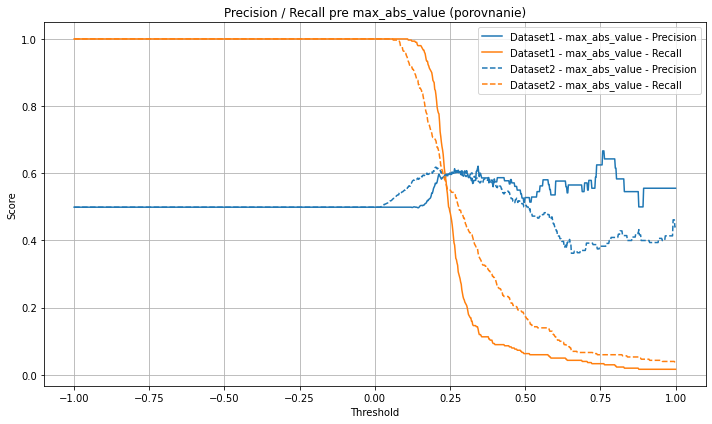

Dataset1 - top_10_avg:
  Precision ≈ Recall ≈ 0.569 at threshold ≈ 0.219
Dataset2 - top_10_avg:
  Precision ≈ Recall ≈ 0.611 at threshold ≈ 0.198


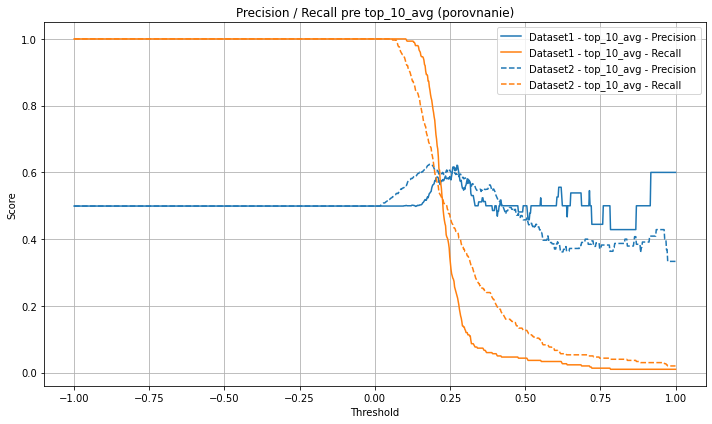

Dataset1 - min_max_diff:
  Precision ≈ Recall ≈ 0.590 at threshold ≈ 0.167
Dataset2 - min_max_diff:
  Precision ≈ Recall ≈ 0.563 at threshold ≈ 0.235


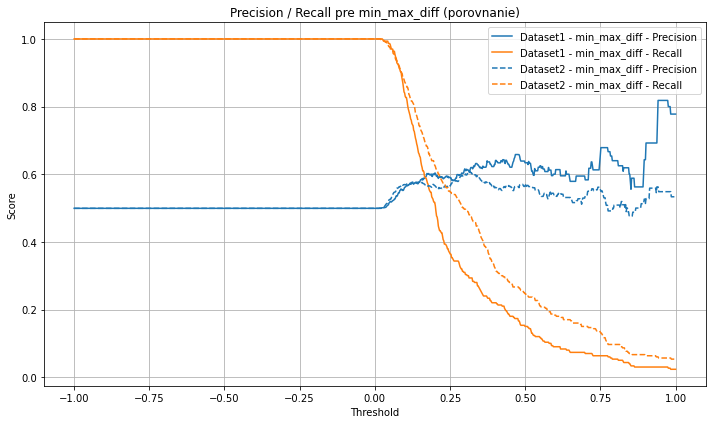

Dataset1 - max_derivative:
  Precision ≈ Recall ≈ 0.607 at threshold ≈ 0.057
Dataset2 - max_derivative:
  Precision ≈ Recall ≈ 0.584 at threshold ≈ 0.063


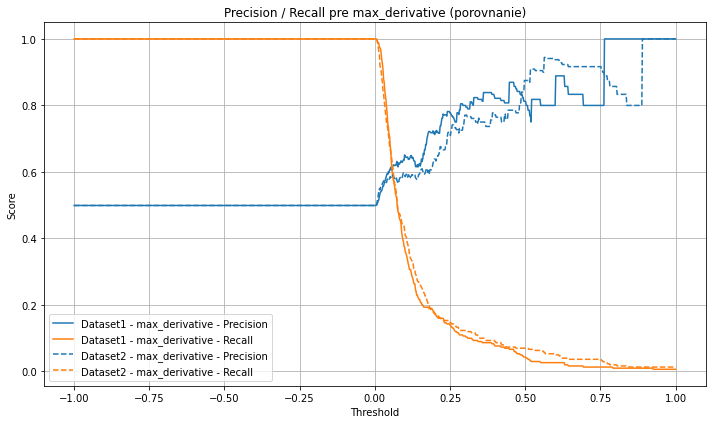

Dataset1 - max_second_derivative:
  Precision ≈ Recall ≈ 0.619 at threshold ≈ 0.079
Dataset2 - max_second_derivative:
  Precision ≈ Recall ≈ 0.601 at threshold ≈ 0.081


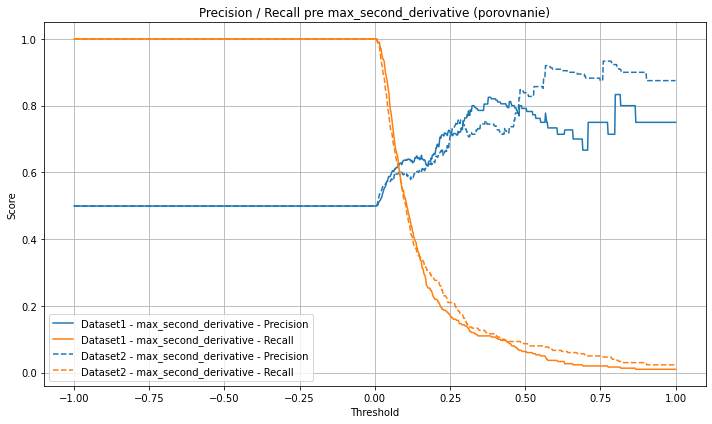

Dataset1 - max_moving_value:
  Precision ≈ Recall ≈ 0.560 at threshold ≈ 0.220
Dataset2 - max_moving_value:
  Precision ≈ Recall ≈ 0.609 at threshold ≈ 0.204


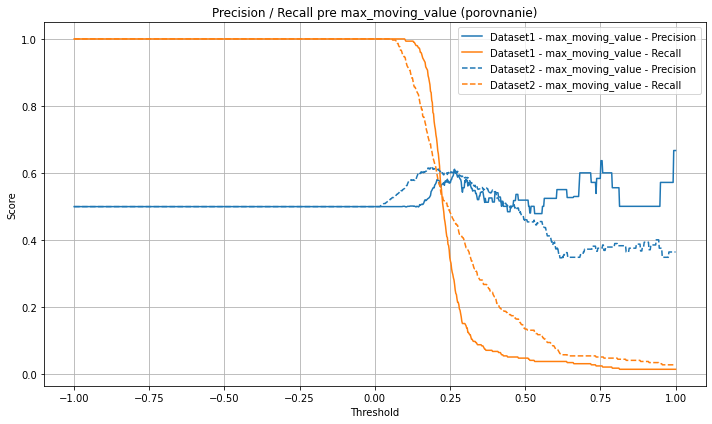

Dataset1 - max_moving_derivative:
  Precision ≈ Recall ≈ 0.584 at threshold ≈ 0.019
Dataset2 - max_moving_derivative:
  Precision ≈ Recall ≈ 0.578 at threshold ≈ 0.024


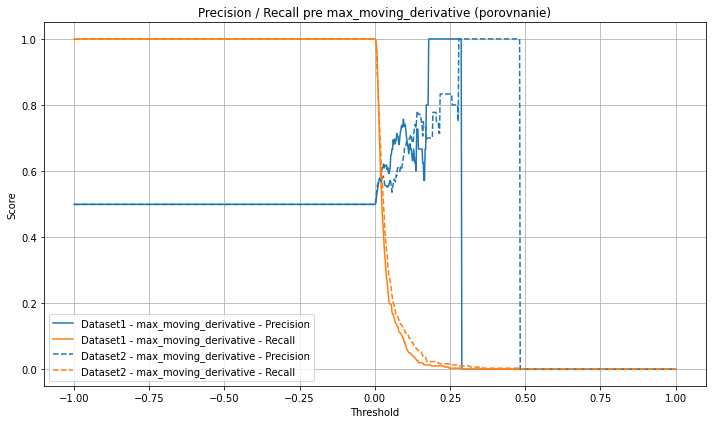

Dataset1 - max_second_moving_derivative:
  Precision ≈ Recall ≈ 0.612 at threshold ≈ 0.015
Dataset2 - max_second_moving_derivative:
  Precision ≈ Recall ≈ 0.587 at threshold ≈ 0.017


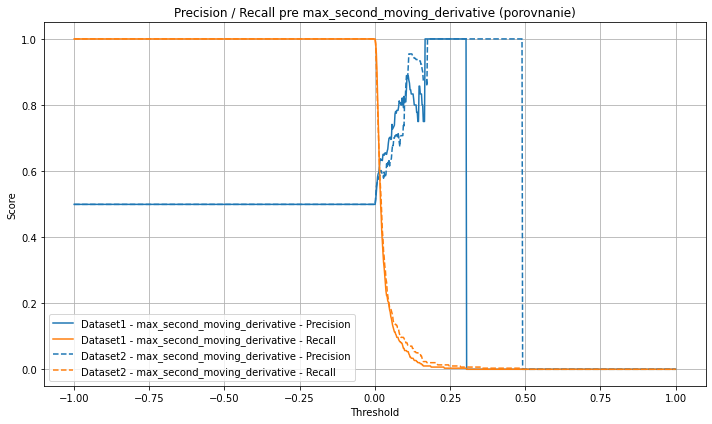

In [4]:
#df1['value'] = df1['value'].abs()
#df2['value'] = df2['value'].abs()

#df1['value'] = df1['value'].where(df1['side'] == 'right', -df1['value'])
#df2['value'] = df2['value'].where(df2['side'] == 'right', -df2['value'])

df_metrics1 = compute_metrics(df1)
df_metrics2 = compute_metrics(df2)


for column in ["max_abs_value", "top_10_avg", "min_max_diff", "max_derivative", "max_second_derivative", "max_moving_value", "max_moving_derivative",
               "max_second_moving_derivative"]:
    evaluate_thresholds_compare(df_metrics1, df_metrics2, column)

Dataset1 - max_abs_value:
  Precision ≈ Recall ≈ 0.648 at threshold ≈ 0.215
Dataset2 - max_abs_value:
  Precision ≈ Recall ≈ 0.597 at threshold ≈ 0.227


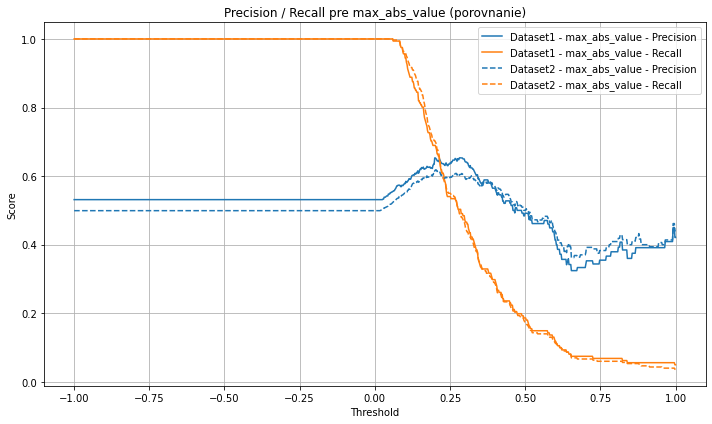

Dataset1 - top_10_avg:
  Precision ≈ Recall ≈ 0.658 at threshold ≈ 0.185
Dataset2 - top_10_avg:
  Precision ≈ Recall ≈ 0.611 at threshold ≈ 0.198


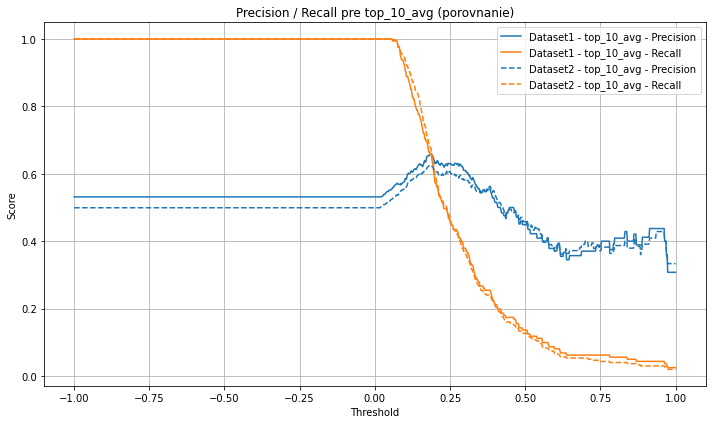

Dataset1 - max_derivative:
  Precision ≈ Recall ≈ 0.609 at threshold ≈ 0.063
Dataset2 - max_derivative:
  Precision ≈ Recall ≈ 0.584 at threshold ≈ 0.063


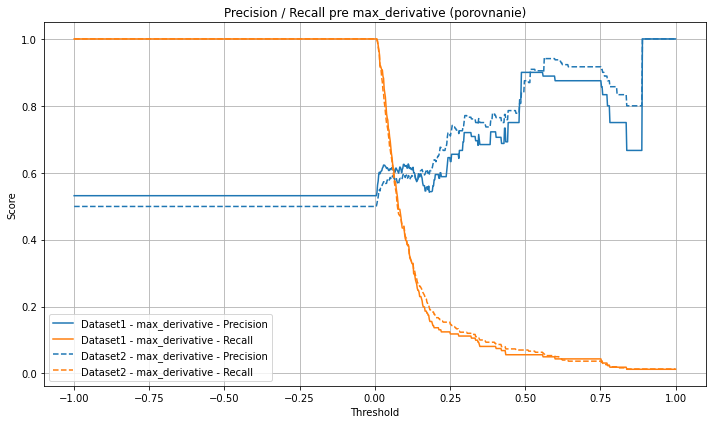

Dataset1 - max_second_derivative:
  Precision ≈ Recall ≈ 0.640 at threshold ≈ 0.081
Dataset2 - max_second_derivative:
  Precision ≈ Recall ≈ 0.601 at threshold ≈ 0.081


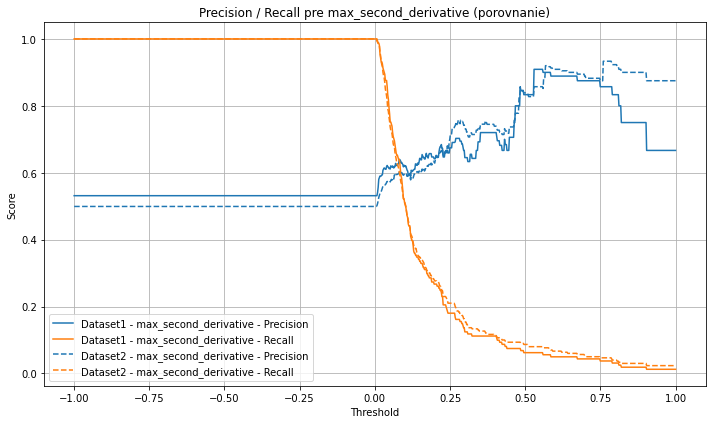

Dataset1 - max_moving_value:
  Precision ≈ Recall ≈ 0.646 at threshold ≈ 0.191
Dataset2 - max_moving_value:
  Precision ≈ Recall ≈ 0.609 at threshold ≈ 0.204


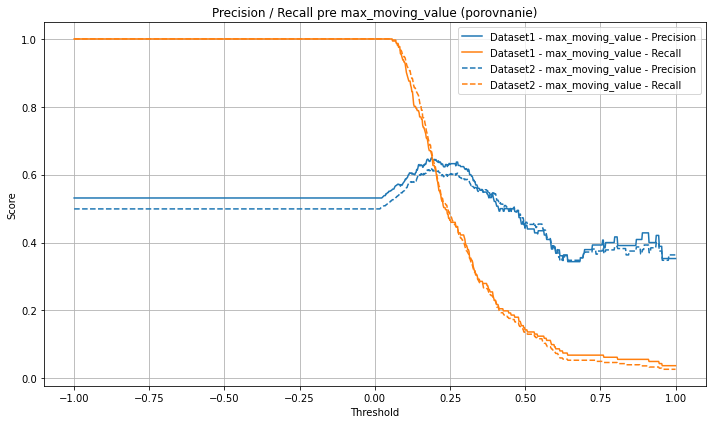

Dataset1 - max_moving_derivative:
  Precision ≈ Recall ≈ 0.618 at threshold ≈ 0.023
Dataset2 - max_moving_derivative:
  Precision ≈ Recall ≈ 0.578 at threshold ≈ 0.024


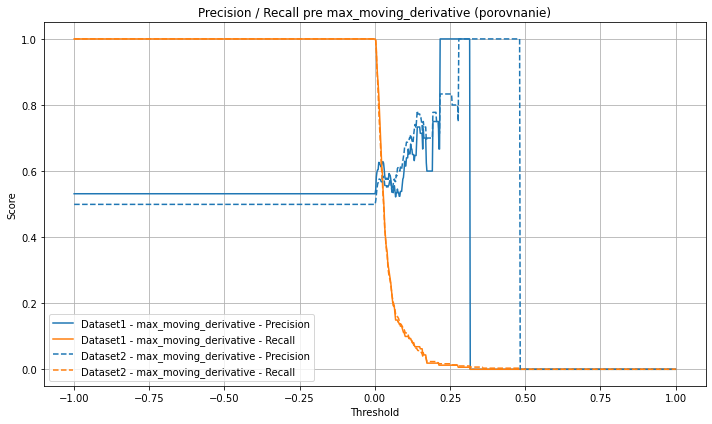

Dataset1 - max_second_moving_derivative:
  Precision ≈ Recall ≈ 0.611 at threshold ≈ 0.016
Dataset2 - max_second_moving_derivative:
  Precision ≈ Recall ≈ 0.587 at threshold ≈ 0.017


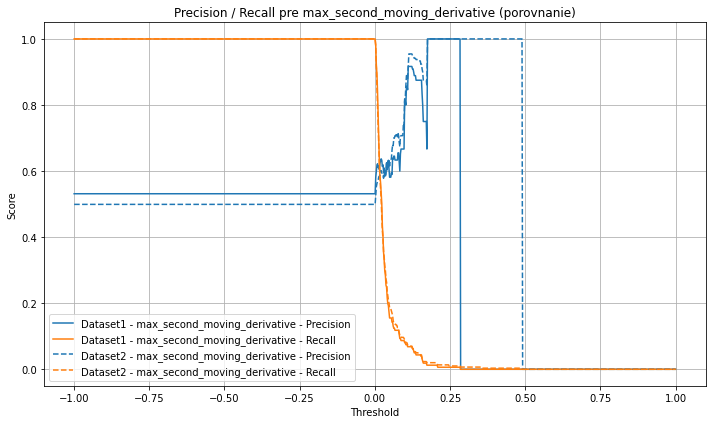

In [5]:

df_metrics1 = compute_metrics(df2[df2['side'] == 'right'])
df_metrics1 = compute_metrics(df2[df2['side'] == 'left'])


for column in ["max_abs_value", "top_10_avg", "max_derivative", "max_second_derivative", "max_moving_value", "max_moving_derivative",
               "max_second_moving_derivative"]:
    evaluate_thresholds_compare(df_metrics1, df_metrics2, column)

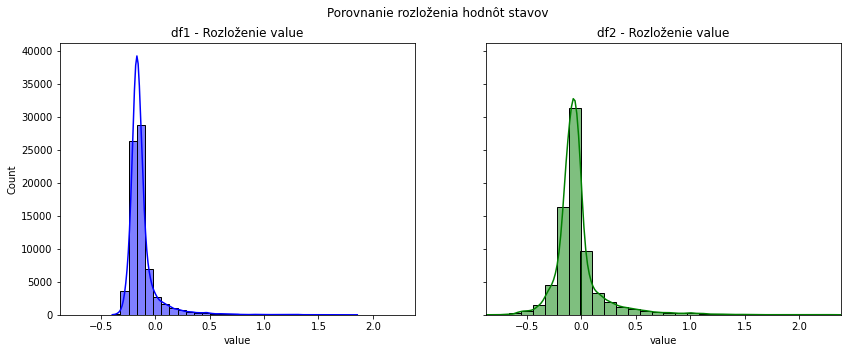

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Spoločné rozsahy ---
vmin = min(df1["value"].min(), df2["value"].min())
vmax = max(df1["value"].max(), df2["value"].max())

# --- Histogram rozdelenia hodnôt ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.histplot(df1["value"], kde=True, bins=30, ax=axs[0], color="blue")
axs[0].set_title("df1 - Rozloženie value")
axs[0].set_xlim(vmin, vmax)

sns.histplot(df2["value"], kde=True, bins=30, ax=axs[1], color="green")
axs[1].set_title("df2 - Rozloženie value")
axs[1].set_xlim(vmin, vmax)

plt.suptitle("Porovnanie rozloženia hodnôt stavov")
plt.show()

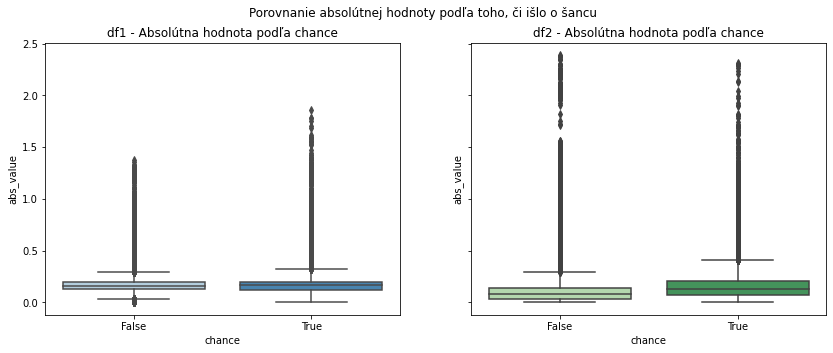

In [7]:
# Pridanie stĺpca s absolútnou hodnotou
df1["abs_value"] = df1["value"].abs()
df2["abs_value"] = df2["value"].abs()

# --- Boxplot podľa chance s absolútnou hodnotou ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.boxplot(data=df1, x="chance", y="abs_value", ax=axs[0], palette="Blues")
axs[0].set_title("df1 - Absolútna hodnota podľa chance")

sns.boxplot(data=df2, x="chance", y="abs_value", ax=axs[1], palette="Greens")
axs[1].set_title("df2 - Absolútna hodnota podľa chance")

plt.suptitle("Porovnanie absolútnej hodnoty podľa toho, či išlo o šancu")
plt.show()

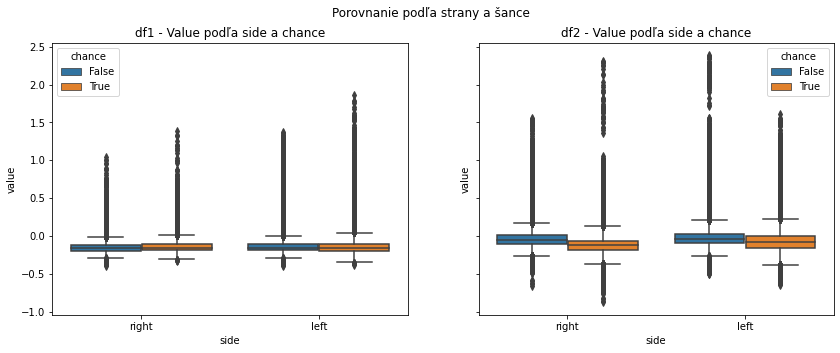

In [8]:
# --- Boxplot podľa side a chance ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.boxplot(data=df1, x="side", y="value", hue="chance", ax=axs[0])
axs[0].set_title("df1 - Value podľa side a chance")

sns.boxplot(data=df2, x="side", y="value", hue="chance", ax=axs[1])
axs[1].set_title("df2 - Value podľa side a chance")

plt.suptitle("Porovnanie podľa strany a šance")
plt.show()

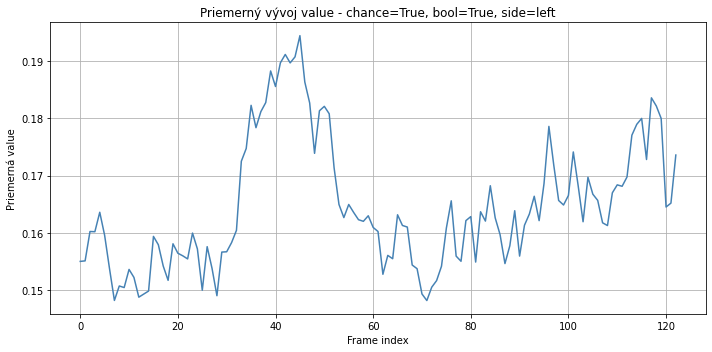

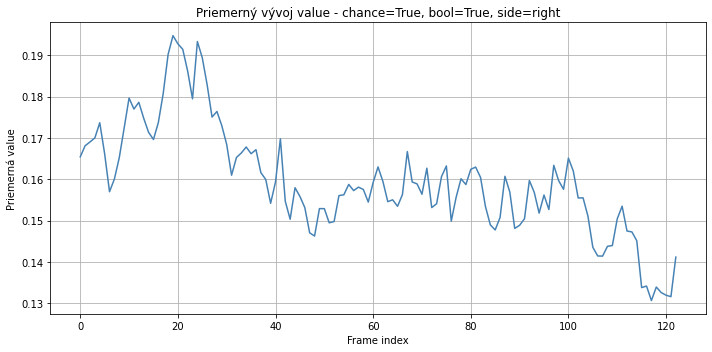

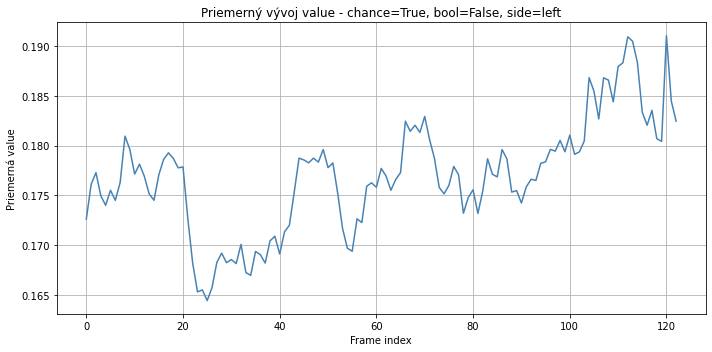

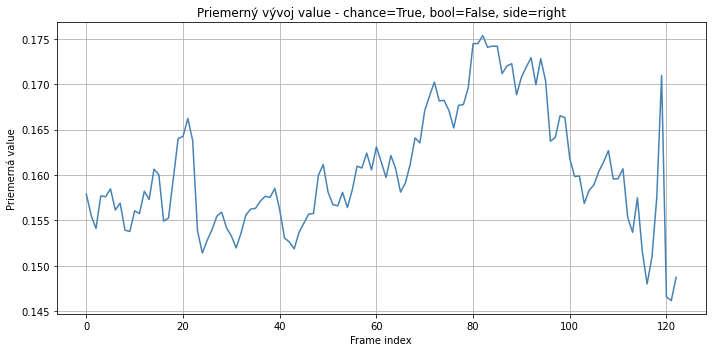

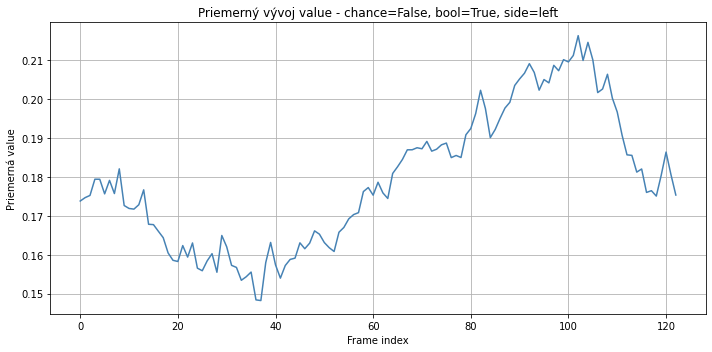

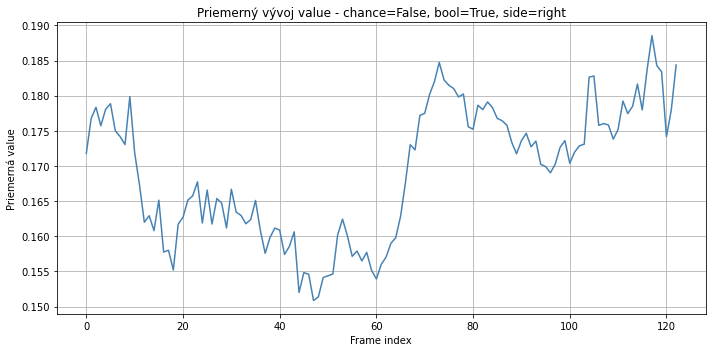

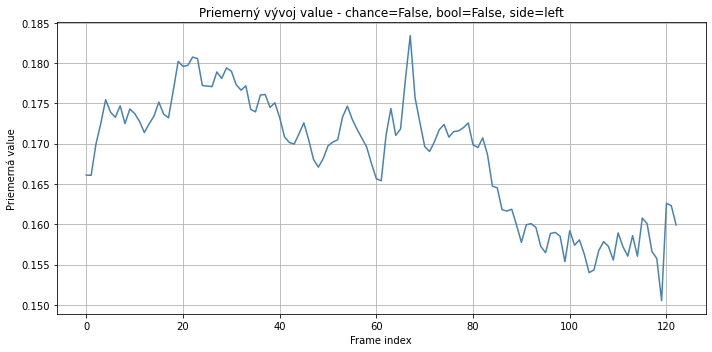

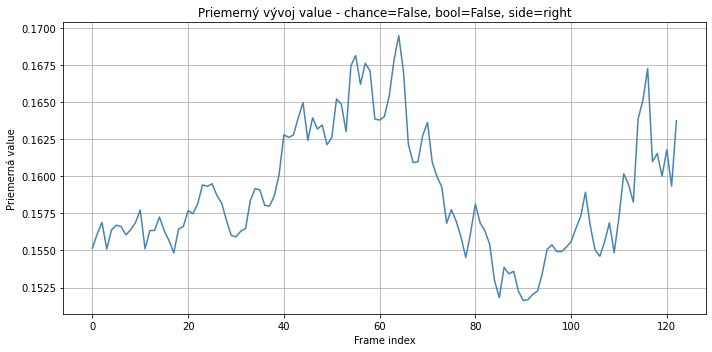

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Zabezpečíme, že indexy vo vnútri akcií sú správne
df1['frame_index'] = df1.groupby('chance_id').cumcount()

# Všetky kombinácie
combinations = [
    ('True', 'True', 'left'),
    ('True', 'True', 'right'),
    ('True', 'False', 'left'),
    ('True', 'False', 'right'),
    ('False', 'True', 'left'),
    ('False', 'True', 'right'),
    ('False', 'False', 'left'),
    ('False', 'False', 'right'),
]

# Pre každý graf
for chance, boolean, side in combinations:
    subset = df1[(df1['chance'].astype(str) == chance) &
                 (df1['bool'].astype(str) == boolean) &
                 (df1['side'] == side)]

    # Vypočítaj priemer value pre každý frame_index
    mean_values = subset.groupby('frame_index')['abs_value'].mean()

    # Vykreslenie
    plt.figure(figsize=(10, 5))
    plt.plot(mean_values.index, mean_values.values, label=f'{chance}, {boolean}, {side}', color='steelblue')
    plt.title(f"Priemerný vývoj value - chance={chance}, bool={boolean}, side={side}")
    plt.xlabel("Frame index")
    plt.ylabel("Priemerná value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


  chance  side value_type    value
0   True  left  max_value -0.02868
1   True  left  max_value -0.07509
2   True  left  max_value -0.09611
3   True  left  max_value -0.03853
4   True  left  max_value -0.03277


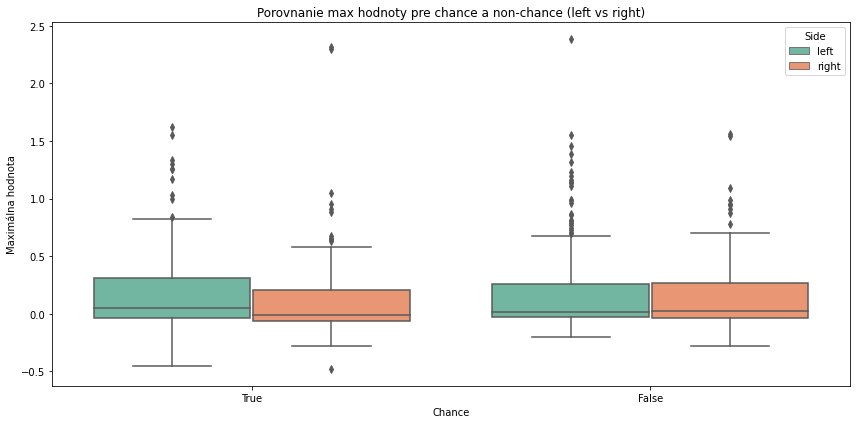

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Predpokladáme, že df je už definovaný a obsahuje tvoje dáta

# Vytvoríme nový DataFrame, ktorý bude obsahovať max hodnoty pre každú skupinu (chance, side)
results = []

# Kombinácie pre chance (True, False) a side (left, right)
for chance in ['True', 'False']:
    for side in ['left', 'right']:
        # Vyberieme subset pre danú šancu a stranu
        subset = df[(df['chance'].astype(str) == chance) & (df['side'] == side)]
        
        # Ak subset nie je prázdny, počítame max hodnoty pre každú šancu a stranu
        if not subset.empty:
            # Pre danú kombináciu chance a side vezmeme maximálnu hodnotu z každého záznamu
            max_values = subset.groupby('chance_id')['value'].max()

            # Uložíme tieto maximálne hodnoty do výsledného DataFrame
            for value in max_values:
                results.append({
                    'chance': chance,
                    'side': side,
                    'value_type': 'max_value',
                    'value': value
                })

# Vytvoríme DataFrame z výsledkov
df_results = pd.DataFrame(results)

# Skontrolujeme obsah DataFrame pred vykreslením grafu
print(df_results.head())

# Vykreslíme boxplot pre max_value
plt.figure(figsize=(12, 6))
sns.boxplot(x="chance", y="value", hue="side", data=df_results, palette="Set2", dodge=True)

# Titulok a popisky
plt.title("Porovnanie max hodnoty pre chance a non-chance (left vs right)")
plt.xlabel("Chance")
plt.ylabel("Maximálna hodnota")
plt.tight_layout()
plt.legend(title="Side")
plt.show()


In [11]:
import numpy as np
from scipy.stats import pearsonr
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def porovnaj_krivku(seq, avg_sanca, avg_nesanca):
    vysledky = {}

    # L2 vzdialenosti
    dist_sanca_l2 = np.linalg.norm(seq - avg_sanca)
    dist_nesanca_l2 = np.linalg.norm(seq - avg_nesanca)
    vysledky['l2'] = 'sanca' if dist_sanca_l2 < dist_nesanca_l2 else 'nesanca'

    # Pearson korelácia
    corr_sanca, _ = pearsonr(seq, avg_sanca)
    corr_nesanca, _ = pearsonr(seq, avg_nesanca)
    vysledky['pearson'] = 'sanca' if corr_sanca > corr_nesanca else 'nesanca'

    # DTW vzdialenosť
    dist_sanca_dtw, _ = fastdtw(seq, avg_sanca, dist=euclidean)
    dist_nesanca_dtw, _ = fastdtw(seq, avg_nesanca, dist=euclidean)
    vysledky['dtw'] = 'sanca' if dist_sanca_dtw < dist_nesanca_dtw else 'nesanca'

    return vysledky

In [22]:
# Pre šance
sanca_matrix = df1[df1["chance"] == True].groupby("chance_id")["abs_value"].apply(lambda x: x.values).to_list()
sanca_matrix = np.vstack(sanca_matrix)  # Každý riadok = jedna akcia
avg_sanca = np.mean(sanca_matrix, axis=0)  # Priemer po stĺpcoch

# Pre nešance
nesanca_matrix = df1[df1["chance"] == False].groupby("chance_id")["abs_value"].apply(lambda x: x.values).to_list()
nesanca_matrix = np.vstack(nesanca_matrix)
avg_nesanca = np.mean(nesanca_matrix, axis=0)

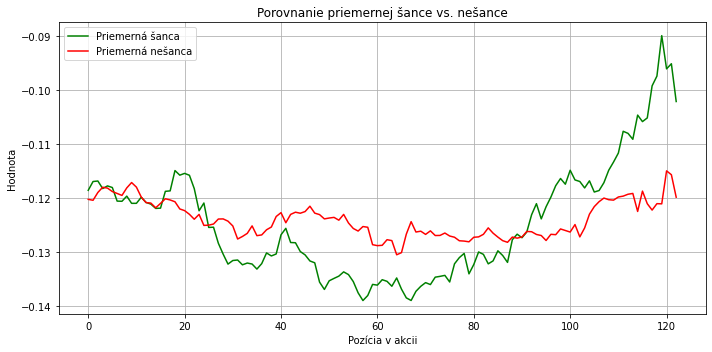

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(avg_sanca, label="Priemerná šanca", color="green")
plt.plot(avg_nesanca, label="Priemerná nešanca", color="red")
plt.xlabel("Pozícia v akcii")
plt.ylabel("Hodnota")
plt.title("Porovnanie priemernej šance vs. nešance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.spatial.distance import euclidean, cosine, cityblock
from scipy.stats import pearsonr
from fastdtw import fastdtw  # Používame fastdtw

def compare_to_avg_all_metrics(avg_sanca, avg_nesanca, df):
    results = []
    grouped = df.groupby("chance_id")["abs_value"].apply(lambda x: x.values)

    for chance_id, values in grouped.items():
        # L2 distance
        l2_sanca = euclidean(values, avg_sanca)
        l2_nesanca = euclidean(values, avg_nesanca)
        l2_score = l2_nesanca - l2_sanca

        # L1 (Manhattan)
        l1_sanca = cityblock(values, avg_sanca)
        l1_nesanca = cityblock(values, avg_nesanca)
        l1_score = l1_nesanca - l1_sanca

        # Pearson correlation
        corr_sanca, _ = pearsonr(values, avg_sanca)
        corr_nesanca, _ = pearsonr(values, avg_nesanca)
        pearson_score = corr_sanca - corr_nesanca

        # Cosine similarity
        cos_sanca = 1 - cosine(values, avg_sanca)
        cos_nesanca = 1 - cosine(values, avg_nesanca)
        cosine_score = cos_sanca - cos_nesanca

        # DTW distance using fastdtw
        dtw_sanca, _ = fastdtw(values, avg_sanca, dist=euclidean)
        dtw_nesanca, _ = fastdtw(values, avg_nesanca, dist=euclidean)
        dtw_score = dtw_nesanca - dtw_sanca

        true_label = df[df["chance_id"] == chance_id]["chance"].iloc[0]

        results.append({
            "chance_id": chance_id,
            "true_label": true_label,
            "l2_score": l2_score,
            "l1_score": l1_score,
            "pearson_score": pearson_score,
            "cosine_score": cosine_score,
            "dtw_score": dtw_score
        })

    return pd.DataFrame(results)


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def find_intersection_threshold(precision, recall, thresholds):
    for i in range(len(thresholds) - 1):
        p1, p2 = precision[i], precision[i + 1]
        r1, r2 = recall[i], recall[i + 1]

        # Skontroluj, či sa krivky pretínajú medzi i a i+1
        if (p1 - r1) * (p2 - r2) < 0:
            # Lineárna interpolácia pre threshold, kde sa pretínajú
            t1, t2 = thresholds[i], thresholds[i + 1]

            # Rozdiely
            dp = p2 - p1
            dr = r2 - r1
            dt = t2 - t1

            # Riešime rovnicu p(t) = r(t)
            alpha = (r1 - p1) / ((dp - dr) + 1e-8)
            t_cross = t1 + alpha * dt

            # Interpoluj aj hodnotu precision = recall
            precision_interp = p1 + alpha * dp
            return t_cross, precision_interp

    # Ak sa nikdy nepretli, vráť najbližší bod
    i = np.argmin(np.abs(np.array(precision) - np.array(recall)))
    return thresholds[i], (precision[i] + recall[i]) / 2

def evaluate_single_metric(df_metrics, column, thresholds=np.linspace(-3, 1, 1000)):
    precision, recall = [], []

    # Iterovanie cez prahy a výpočet precision a recall
    for t in thresholds:
        preds = df_metrics[column] > t
        tp = ((preds == True) & (df_metrics["true_label"] == True)).sum()
        fp = ((preds == True) & (df_metrics["true_label"] == False)).sum()
        fn = ((preds == False) & (df_metrics["true_label"] == True)).sum()

        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)

        precision.append(prec)
        recall.append(rec)

    # Hľadanie priesečníka medzi Precision a Recall
    best_threshold, min_diff = find_intersection_threshold(precision, recall, thresholds)

    # Výpis najlepšieho prahu
    print(f"{column}:")
    print(f"  Priesečník Precision a Recall ≈ {min_diff:.3f} pri prahu ≈ {best_threshold:.3f}")

    # Plotovanie Precision/Recall krivky
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision, label="Precision")
    plt.plot(thresholds, recall, label="Recall")

    # Zobrazenie priesečníka v grafe
    plt.axvline(best_threshold, color='gray', linestyle='--', label=f"Best intersection ≈ {best_threshold:.3f}")

    # Ďalšie nastavenia grafu
    plt.title(f"Precision / Recall pre {column}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


l2_score:
  Priesečník Precision a Recall ≈ 0.537 pri prahu ≈ -0.002


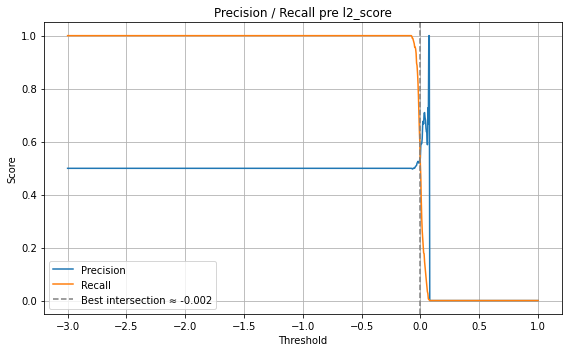

l1_score:
  Priesečník Precision a Recall ≈ 0.510 pri prahu ≈ 0.071


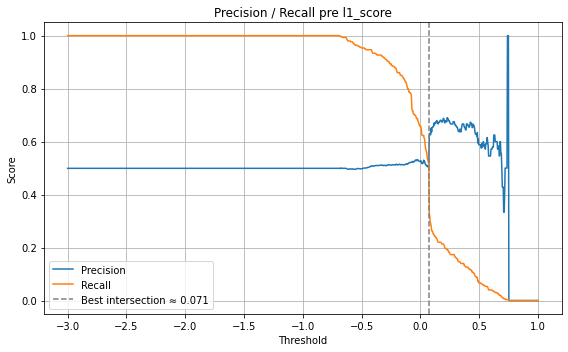

pearson_score:
  Priesečník Precision a Recall ≈ 0.544 pri prahu ≈ -0.007


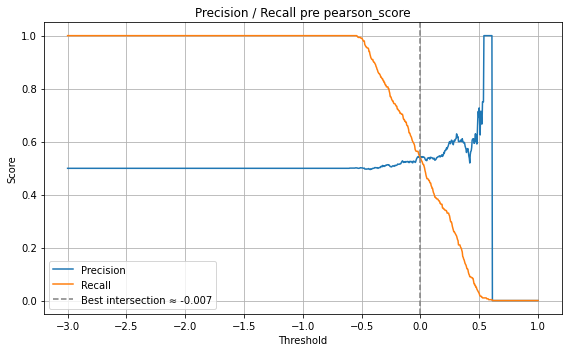

cosine_score:
  Priesečník Precision a Recall ≈ 0.548 pri prahu ≈ -0.003


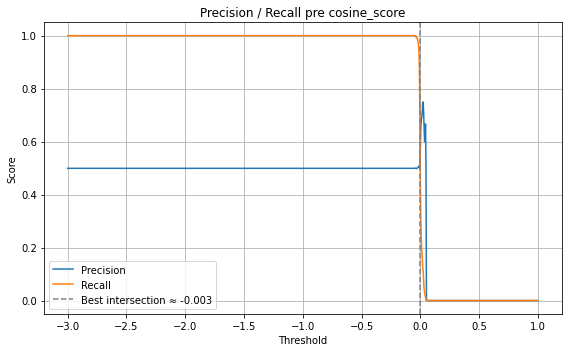

dtw_score:
  Priesečník Precision a Recall ≈ 0.547 pri prahu ≈ 0.127


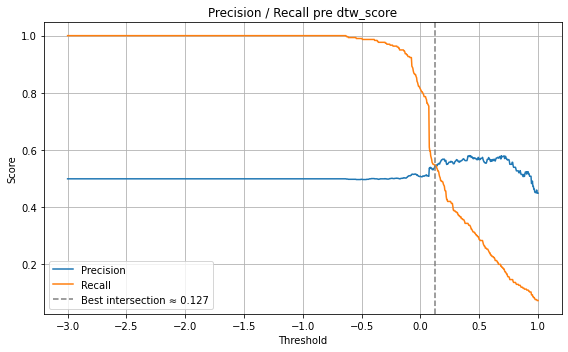

In [21]:
df_scores = compare_to_avg_all_metrics(avg_sanca, avg_nesanca, df1)

for metric in ["l2_score", "l1_score", "pearson_score", "cosine_score", "dtw_score"]:
    evaluate_single_metric(df_scores, metric)
